### SR-GNN exercise 
- used data : kaggle competition (https://www.kaggle.com/retailrocket/ecommerce-dataset)
- reference : https://colab.research.google.com/drive/1XwQ0njqSZL8vbHJMnRRHlH4ar0kYYFVz?usp=sharing#scrollTo=MKM4wAYG9ssq
- medium : https://medium.com/stanford-cs224w/buy-this-session-based-recommendation-using-sr-gnn-d3415e393722
- after-report : https://velog.io/@seojeongbin

In [1]:
# Import Python built-in libraries
import copy
import pickle
import random
import time
import math
# Import pip libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

# Import torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

# Import PyG packages
import torch_geometric as pyg
import torch_geometric.data as pyg_data
from torch_geometric.typing import Adj, OptTensor
import torch_sparse

## 1. Data Processing

In [2]:
data_path = r'C:\Users\SeoJeongBin\Desktop\Code\Recommendation\data\SR-GNN\events.csv\events.csv'
events_df = pd.read_csv(data_path)
print(events_df.head(3))
len(events_df)

       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN


2756101

In [3]:
print(events_df['event'].unique()) # 3types
print(events_df['transactionid'].unique()) # unique type (only for transaction)

['view' 'addtocart' 'transaction']
[   nan  4000. 11117. ...  4385. 13872. 17579.]


In [4]:
print(min(events_df['itemid']))
print(max(events_df['itemid']))
print(min(events_df['visitorid']))
print(max(events_df['visitorid']))


3
466867
0
1407579


### 1-1. Separating log data into sessions
- event == view 인 경우만 처리
- 방문 2회 이상 고객 대상 분석 (그래야 session 이란걸 정의할 수 있으니)
- session을 두시간으로 정의

In [5]:
# 1. filter only the 'view' events
events_df_filtered = events_df.loc[events_df['event']=='view',:] # loc 내부 순서 실수 주의
events_df_filtered

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [6]:
# 2. filter out visitors with single clicks
visit_counts_per_visitor = events_df_filtered.value_counts(dropna=False)
visit_counts_per_visitor # 중복횟수를 우측에 카운트되게 나옴, 자동 내림차순(dropna=false는 nan값을 무시하지 않게 해줌)

timestamp      visitorid  event  itemid  transactionid
1438650539084  951289     view   5190    NaN              3
1435308445514  1152713    view   427254  NaN              3
1440044157440  1177355    view   161623  NaN              2
1434468685577  618116     view   73917   NaN              2
1439830202573  515669     view   56500   NaN              2
                                                         ..
1434504724447  1270836    view   53959   NaN              1
1434504725643  562087     view   351415  NaN              1
1434504726584  1326048    view   316575  NaN              1
1434504727158  794304     view   293458  NaN              1
1442545187788  1287495    view   98299   NaN              1
Length: 2664218, dtype: int64

In [7]:
visit_counts_per_visitor = events_df_filtered['visitorid'].value_counts(dropna=False)
visit_counts_per_visitor

1150086    6479
530559     3623
895999     2368
152963     2304
163561     2194
           ... 
908147        1
258979        1
551045        1
218233        1
1184451       1
Name: visitorid, Length: 1404179, dtype: int64

In [8]:
visitors_with_significant_visits = visit_counts_per_visitor[visit_counts_per_visitor > 1].index # 방문을 1번 넘게한 user
events_df_filtered = events_df_filtered[events_df_filtered['visitorid'].isin(visitors_with_significant_visits)] # visitorid가 visitors_with_significant_visits 리스트에 속하는 경우만 반환
events_df_filtered

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
5,1433224086234,972639,view,22556,NaN
...,...,...,...,...,...
2756092,1438398473572,709520,view,104512,NaN
2756094,1438399289446,701750,view,296172,NaN
2756095,1438400574346,289041,view,156947,NaN
2756098,1438397820527,1251746,view,78144,NaN


In [9]:
# 'visits_by_visitors'
# Let's group events and their timing data.
import time # 이거 시간 꽤 걸림 (로컬기준 2분정도) => 셀 단위 특성 상 다시돌리는일많으니 이런거는 아예 저장을 시켜버려야함
start = time.time()

visits_by_visitors = {}
for _, row in enumerate(tqdm(events_df_filtered.iterrows())): # tqdm : 진행률 보여줌 / iterrows : df행 단위로 받아올 수 있음. 튜플임 (행넘버, 내용 시리즈 객체)
    timestamp, visitorid, event, itemid, transactionid = row[1].values

    if visitorid not in visits_by_visitors:
        visits_by_visitors[visitorid] = {'itemids': [], 'timestamps': []} # 전체 df돌면서 visitor마다 딕셔너리 키 생성해주고
    visits_by_visitors[visitorid]['itemids'].append(itemid)
    visits_by_visitors[visitorid]['timestamps'].append(timestamp)

# print(visits_by_visitors)
# 257597: {'itemids': [355908, 302696], 'timestamps': [1433221332117, 1433800821247]} 이런식으로 사용자 id별로 저장됨
print(f'There are {len(visits_by_visitors)} visitors left.') # len(events_df_filtered['visitorid'].unique()) 걍 이거랑 똑같음
print(f'소요시간 : {time.time() - start}') 

1656582it [02:30, 11042.79it/s]

There are 396449 visitors left.
소요시간 : 150.02483201026917


In [10]:
# 'sessions_by_visitors'
# We will separate sessions by 2 hours.
delay = 2 * 3600 * 1000

# 위에서 정의한 visits_by_visitors 딕셔너리를 통해 sessions_by_visitors 만들기
sessions_by_visitors = {}
for visitorid, visitor_dict in visits_by_visitors.items():
    sessions = [[]]
    events_sorted = sorted(zip(visitor_dict['timestamps'], visitor_dict['itemids']))
    for i in range(len(events_sorted) - 1):
        sessions[-1].append(events_sorted[i][1])
        if (events_sorted[i+1][0] - events_sorted[i][0]) > delay:
            sessions.append([])
    sessions[-1].append(events_sorted[len(events_sorted) - 1][1])
    sessions_by_visitors[visitorid] = sessions

# print(sessions_by_visitors)
# 이용자별로 session을 만드는과정임 고객 A : [[1시],[2시,2시10분,2시15분]] 이런느낌
print()
print(f'len(sessions_by_visitors : {len(sessions_by_visitors)}')


len(sessions_by_visitors : 396449


### 1-2. Splitting train and test dataset
- 위에서 정의한 sessions_by_visitors 기준으로한 dataset 분할하기
- now let's split data (train, valid, test) by user ids
    - each user will only be found in one of the three splits
    - We split like this because the model may 'cheat' from partial sessions of a user during training and use that information during test time.
- 원래 추천시스템에서 데이터 분할하는게 일반적인 방법이랑 조금 다름
    - 참고 : https://data-newbie.tistory.com/842

In [11]:
# Adjsut sampling rate ([0, 1]) to generate smaller datasets.
# Setting `sampling_rate` to 1 will lead to a full dataset split.
sampling_rate = 1
seed = 42 # random seed for reproducibility
all_visitors = list(sessions_by_visitors.keys()) # 실수주의 : key()가 아니라 keys()임
random.Random(seed).shuffle(all_visitors)

num_train = int(len(all_visitors) * 0.8 * sampling_rate)
num_val = int(len(all_visitors) * 0.1 * sampling_rate)
num_test = int(len(all_visitors) * 0.1 * sampling_rate)

train_visitors = all_visitors[:num_train]
val_visitors = all_visitors[num_train : num_train+num_val]
test_visitors = all_visitors[num_train+num_val:num_train+num_val+num_test]

print(f'train, val, and test visitors: {len(train_visitors), len(val_visitors), len(test_visitors)}')
# print(f'test_visitors : {test_visitors}') # visitors의 번호가 커다란 리스트에 하나로 다 들어가있는 형태임

train, val, and test visitors: (317159, 39644, 39644)


In [12]:
# 위에는 user만 하였으니 session도 train val test 나누어준다
# each session => subsession (논문이 이런식으로 했음)
def extract_subsessions(sessions):
    """Extracts all partial sessions from the sessions given.

    For example, a session (1, 2, 3) should be augemnted to produce two
    separate sessions (1, 2) and (1, 2, 3).
    """
    all_sessions = []
    for session in sessions:
        for i in range(1, len(session)):
            all_sessions.append(session[:i+1])
    return all_sessions

In [13]:
# Get sessions of each visitor, generate subsessions of each session, and put all the generated subsessions into right splits.
# We generate subsessions according to the dataset generation policy suggested by the original SR-GNN paper.
train_sessions, val_sessions, test_sessions = [], [], []
for visitor in train_visitors:
    train_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))
for visitor in val_visitors:
    val_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))
for visitor in test_visitors:
    test_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))
    
print(f'train, val, and test sessions: {len(train_sessions), len(val_sessions), len(test_sessions)}')

train, val, and test sessions: (781928, 91317, 96896)


In [14]:
test_sessions

[[432992, 454422],
 [432992, 454422, 118551],
 [432992, 454422, 118551, 314073],
 [432992, 454422, 118551, 314073, 118551],
 [432992, 454422, 118551, 314073, 118551, 432478],
 [432992, 454422, 118551, 314073, 118551, 432478, 303828],
 [16976, 16976],
 [16976, 16976, 16976],
 [321905, 168367],
 [321905, 168367, 407929],
 [321905, 168367, 407929, 327424],
 [321905, 168367, 407929, 327424, 388755],
 [321905, 168367, 407929, 327424, 388755, 453290],
 [242938, 242938],
 [265026, 250618],
 [265026, 250618, 265026],
 [265026, 250618, 265026, 265026],
 [265026, 250618, 265026, 265026, 265026],
 [289123, 310576],
 [289123, 310576, 154123],
 [289123, 310576, 154123, 154123],
 [289123, 310576, 154123, 154123, 409789],
 [289123, 310576, 154123, 154123, 409789, 9276],
 [289123, 310576, 154123, 154123, 409789, 9276, 222721],
 [308296, 257655],
 [284252, 284252],
 [318106, 318106],
 [318008, 136521],
 [318008, 136521, 136521],
 [136521, 210534],
 [153743, 376485],
 [352096, 24713],
 [352096, 24713, 3

In [15]:
# session을 train,val,test 별로 저장한다
with open('raw/train.txt', 'wb') as f:
    pickle.dump(train_sessions, f)
with open('raw/val.txt', 'wb') as f:
    pickle.dump(val_sessions, f)
with open('raw/test.txt', 'wb') as f:
    pickle.dump(test_sessions, f)

## 2. Data Pipeline (tabular => graph)
- 이거 잘되면 시각화도 하기!!
- pyg InMemryDataset 방식 : https://www.youtube.com/watch?v=QLIkOtKS4os&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=8
    - 이 영상을 '마음으로' 이해해야 나중에 다른방식으로도 활용할 수 있을듯!!!!
- pandas 방식 : https://www.youtube.com/watch?v=AQU3akndun4&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=23

In [1]:
class GraphDataset(pyg_data.InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.file_name = file_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [f'{self.file_name}.txt']

    @property
    def processed_file_names(self): # 밑에 process과정이 끝나면 processed/ 밑에 ~~.pt로 저장됨
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def process(self):
        raw_data_file = f'{self.raw_dir}/{self.raw_file_names[0]}'
        with open(raw_data_file, 'rb') as f:
            sessions = pickle.load(f)
        data_list = []

        for session in sessions:
            session, y = session[:-1], session[-1]
            codes, uniques = pd.factorize(session)
            senders, receivers = codes[:-1], codes[1:]

            # Build Data instance
            edge_index = torch.tensor([senders, receivers], dtype=torch.long) # 이웃관계 나타내는 2개열을 갖는 2차원 텐서 : 송신자, 수신자 (여기서는 방향있는 그래프임)
            x = torch.tensor(uniques, dtype=torch.long).unsqueeze(1) # original unique item id
            y = torch.tensor([y], dtype=torch.long) # 각 세션에서 마지막 아이템
            data_list.append(pyg_data.Data(x=x, edge_index=edge_index, y=y))
            

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

NameError: name 'pyg_data' is not defined

- 학습 전 graph 시각화

In [ ]:
train_dataset = GraphDataset('./', 'train')
train_len = len(train_dataset)
print(train_len)

data_y = []
for i in tqdm(range(train_len)):
    data_y.append(train_dataset[i].y)
data_y = torch.cat(data_y,0)

print(len(data_y))
data_y

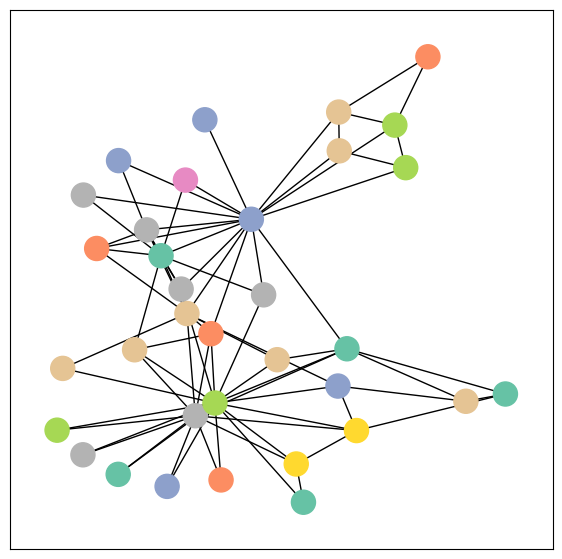

소요시간 : 0.2690591812133789


In [66]:
# 다른 폴더에 있는 시각화 모듈 불러오기 (sys.path.append를 쓰면서 절대경로로 공통상위까지 잡는게 포인트임!)
import sys
sys.path.append(r'C:\Users\SeoJeongBin\Desktop\Code\Recommendation')
import NetworkX.visualize

# 이거같은경우에는 subgraph 별 item node 화살표임.
# 일단 여기 visualize 함수는 노드 classification인 경우란걸 알기 (그리고 학습했으면 epoch, loss도 받을 수 있다!)
from torch_geometric.utils import to_networkx
train_dataset = GraphDataset('./', 'train')

# train_dataset = to_networkx(train_dataset, to_undirected=True)
visualize(train_dataset, color=data_y[:34]) # 왠지 모르겠으나 34만됨..........


In [ ]:
# nx 이용해서 그림그리기 https://velog.io/@djm0727/ML-with-Graph-Colab0#visualization
# 이종노드라는 점, 문제의 목적에 따라 시각화 방법을 달리해야할듯
import networkx as nx

## Model Design
our gated session graph layer has two main parts
- 1. message propagation to create an adjacency matrix(self.propage)
- 2. the grou cell(self.gru)
    - we will put these inside the forward() function
    - We only use one layer for our GatedSessionGraphConv implementation for simplicity. Also, our sessions have average length < 5, so we do not need a large receptive field.

In [ ]:
# 메모
'''
이해하기 상당히 어려운것들이 몇가지 있음
- channel 의미
- gated~가 무엇인지
- propagate가 무엇인지
- aggregate가 무엇인지
일단 검색결과 gnn 중에서도 pyg에 해당하는 사항, 이거는 rnn 관련이란걸 알게됨. gatedgnn이 gnn += rnn인듯. gru는 lstm 이후 나온 장기기억 방법..음..
'''

'\n이해하기 상당히 어려운것들이 몇가지 있음\n- channel 의미\n- gated~가 무엇인지\n- propagate가 무엇인지\n- aggregate가 무엇인지\n일단 검색결과 gnn 중에서도 pyg에 해당하는 사항, 이거는 rnn 관련이란걸 알게됨. gatedgnn이 gnn += rnn인듯. gru는 lstm 이후 나온 장기기억 방법..음..\n'

In [ ]:
class GatedSessionGraphConv(pyg.nn.MessagePassing):
    def __init__(self, out_channels, aggr : str = 'add', **kwargs):
        super().__init__(aggr=aggr, **kwargs)
        
        self.out_channels = out_channels # channel이 뭘까..
        self.gru = torch.nn.GRUCell(out_channels, out_channels, bias=False)
        
    def forward(self, x, edge_index):
        m = self.propagate(edge_index, x=x, size=None)
        x = self.gru(m,x)
        return x
    
    def message(self, x_j): # 이거 네이밍에 주의해야한다는 것 같았음
        return x_j
    
    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

In [ ]:
class SRGNN(nn.Module):
    def __init__(self, hidden_size, n_items):
        super(SRGNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items

        self.embedding = nn.Embedding(self.n_items, self.hidden_size)
        self.gated = GatedSessionGraphConv(self.hidden_size) # 저위에서 선언하고 이걸 객체로 받은느낌인데.. 다시한번 passing 대해서 두개 글 읽어보기

        self.q = nn.Linear(self.hidden_size, 1)
        self.W_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_3 = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, data):
        x, edge_index, batch_map = data.x, data.edge_index, data.batch

        # (0)
        embedding = self.embedding(x).squeeze()

        # (1)-(5)
        v_i = self.gated(embedding, edge_index)

        # Divide nodes by session
        # For the detailed explanation of what is happening below, please refer
        # to the Medium blog post.
        sections = list(torch.bincount(batch_map).cpu())
        v_i_split = torch.split(v_i, sections)

        v_n, v_n_repeat = [], []
        for session in v_i_split:
            v_n.append(session[-1])
            v_n_repeat.append(
                session[-1].view(1, -1).repeat(session.shape[0], 1))
        v_n, v_n_repeat = torch.stack(v_n), torch.cat(v_n_repeat, dim=0)

        q1 = self.W_1(v_n_repeat)
        q2 = self.W_2(v_i)

        # (6)
        alpha = self.q(F.sigmoid(q1 + q2))
        s_g_split = torch.split(alpha * v_i, sections)

        s_g = []
        for session in s_g_split:
            s_g_session = torch.sum(session, dim=0)
            s_g.append(s_g_session)
        s_g = torch.stack(s_g)

        # (7)
        s_l = v_n
        s_h = self.W_3(torch.cat([s_l, s_g], dim=-1))

        # (8)
        z = torch.mm(self.embedding.weight, s_h.T).T
        return z

## Model Training

In [ ]:
# Define the hyperparameters.
# Code taken from 2021 Fall CS224W Colab assignments.
args = {
    'batch_size': 100,
    'hidden_dim': 32,
    'epochs': 10, # 100
    'l2_penalty': 0.00001,
    'weight_decay': 0.1,
    'step': 30,
    'lr': 0.001,
    'num_items': 466868}

class objectview(object): # 이게뭐여
    def __init__(self, d): 
        self.__dict__ = d

args = objectview(args)

In [ ]:
device = 'cpu'
# device = 'cuda' 코랩 gpu로 돌린다면 꼭 이거로 바꾸기

In [ ]:
def train(args):
    # Prepare data pipeline
    train_dataset = GraphDataset('./', 'train')
    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=args.batch_size,
                                       shuffle=False,
                                       drop_last=True)
    val_dataset = GraphDataset('./', 'val')
    val_loader = pyg_data.DataLoader(val_dataset,
                                     batch_size=args.batch_size,
                                     shuffle=False,
                                     drop_last=True)

    # Build model
    model = SRGNN(args.hidden_dim, args.num_items).to(device)

    # Get training components
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=args.lr,
                                 weight_decay=args.l2_penalty)
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step,
                                          gamma=args.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Train
    losses = []
    test_accs = []
    top_k_accs = []

    best_acc = 0
    best_model = None

    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for _, batch in enumerate(tqdm(train_loader)):
            batch.to(device)
            optimizer.zero_grad()

            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()

        if epoch % 1 == 0:
          test_acc, top_k_acc = test(val_loader, model, is_validation=True)
          print(test_acc)
          test_accs.append(test_acc)
          top_k_accs.append(top_k_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
  
    return test_accs, top_k_accs, losses, best_model, best_acc, val_loader

In [ ]:
def test(loader, test_model, is_validation=False, save_model_preds=False):
    test_model.eval()

    # Define K for Hit@K metrics.
    k = 20
    correct = 0
    top_k_correct = 0

    for _, data in enumerate(tqdm(loader)):
        data.to(device)
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            score = test_model(data)
            pred = score.max(dim=1)[1]
            label = data.y

        if save_model_preds:
          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('pred.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

        # We calculate Hit@K accuracy only at test time.
        if not is_validation:
            score = score.cpu().detach().numpy()
            for row in range(pred.size(0)):
                top_k_pred = np.argpartition(score[row], -k)[-k:]
                if label[row].item() in top_k_pred:
                    top_k_correct += 1
    
    if not is_validation:
        return correct / len(loader), top_k_correct / len(loader)
    else:
        return correct / len(loader), 0

In [ ]:
# epochs 10으로 해도 하루종일 걸림. 진짜 학습이 목적이라면 무조건 코랩 gpu로 돌려야함

start = time.time()

test_accs, top_k_accs, losses, best_model, best_acc, test_loader = train(args) 

print(test_accs, top_k_accs)
print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - ")
plt.plot(test_accs, label="test accuracy" + " - ")
plt.legend()
plt.show()

print(f'\n *소요시간 : {time.time() - start}')

 22%|██▏       | 1711/7819 [48:59<2:54:55,  1.72s/it]


KeyboardInterrupt: 